In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import ipywidgets as widgets
from matplotlib.ticker import FuncFormatter
from scipy.signal import butter, lfilter, iirpeak, iirnotch
from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import freqz
from IPython.display import display, HTML
import pyfar as pf
from functools import partial

%matplotlib widget

plt.clf()

plt.close('all')

### Import audio ###

In [2]:
audio = {}
audio["airport"] = pf.io.read_audio("./airport.wav")
audio["white_noise"] = pf.signals.noise(2**22, rms=[1, 1])
audio["jet_engine"] = pf.io.read_audio("./jet_engines.mp3")

print(np.shape(audio["airport"].freq))
print(np.shape(audio["airport"].frequencies))

(2, 640743)
(640743,)


### Define Audio Player Widgets ###

In [14]:
print(sd.query_devices())

# Play audio
def play_audio(audio, sample_rate):
    sd.play(audio.time.T, sample_rate)


# Stop audio
def stop_audio(b):
    sd.stop()



def create_play_button(description, signal):
    button = widgets.Button(description=description)
    button.layout = widgets.Layout(border='1px solid black', border_radius='10px')
    button.on_click(lambda b, audio=signal: play_audio(audio, audio.sampling_rate))
    button.layout.width = '250px'
    return button

stop_button = widgets.Button(description="Stop Audio")
stop_button.layout = widgets.Layout(border='1px solid black', border_radius='10px')
stop_button.on_click(stop_audio)


# Custom CSS to style the ipywidget buttons
custom_css = """
<style>
    .jupyter-widgets button {
        background-color: white !important;
        border: 1px solid black !important;
        border-radius: 10px !important;
        margin: 10px;
    }
    .widget-container {
        display: flex;
        flex-direction: row;
        justify-content: start;
        align-items: center;
    }
</style>
"""

# Display the custom CSS
display(HTML(custom_css))


   0 Microsoft Soundmapper - Input, MME (2 in, 0 out)
>  1 Microphone Array (AMD Audio Dev, MME (2 in, 0 out)
   2 Microsoft Soundmapper - Output, MME (0 in, 2 out)
<  3 Lautsprecher (Realtek(R) Audio), MME (0 in, 2 out)
   4 Primärer Soundaufnahmetreiber, Windows DirectSound (2 in, 0 out)
   5 Microphone Array (AMD Audio Device), Windows DirectSound (2 in, 0 out)
   6 Primärer Soundtreiber, Windows DirectSound (0 in, 2 out)
   7 Lautsprecher (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
   8 Lautsprecher (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
   9 Microphone Array (AMD Audio Device), Windows WASAPI (2 in, 0 out)
  10 Mikrofon (Realtek HD Audio Mic input), Windows WDM-KS (2 in, 0 out)
  11 Speakers 1 (Realtek HD Audio output with HAP), Windows WDM-KS (0 in, 2 out)
  12 Speakers 2 (Realtek HD Audio output with HAP), Windows WDM-KS (0 in, 2 out)
  13 PC-Lautsprecher (Realtek HD Audio output with HAP), Windows WDM-KS (2 in, 0 out)
  14 Speakers 3 (Realtek HD Audio output

No such comm: 87267af3e9bb425ea01b8986a5d32aa1


   0 Microsoft Soundmapper - Input, MME (2 in, 0 out)
>  1 Microphone Array (AMD Audio Dev, MME (2 in, 0 out)
   2 Microsoft Soundmapper - Output, MME (0 in, 2 out)
<  3 Lautsprecher (Realtek(R) Audio), MME (0 in, 2 out)
   4 Primärer Soundaufnahmetreiber, Windows DirectSound (2 in, 0 out)
   5 Microphone Array (AMD Audio Device), Windows DirectSound (2 in, 0 out)
   6 Primärer Soundtreiber, Windows DirectSound (0 in, 2 out)
   7 Lautsprecher (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
   8 Lautsprecher (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
   9 Microphone Array (AMD Audio Device), Windows WASAPI (2 in, 0 out)
  10 Mikrofon (Realtek HD Audio Mic input), Windows WDM-KS (2 in, 0 out)
  11 Speakers 1 (Realtek HD Audio output with HAP), Windows WDM-KS (0 in, 2 out)
  12 Speakers 2 (Realtek HD Audio output with HAP), Windows WDM-KS (0 in, 2 out)
  13 PC-Lautsprecher (Realtek HD Audio output with HAP), Windows WDM-KS (2 in, 0 out)
  14 Speakers 3 (Realtek HD Audio output

### Define Filters ###

In [4]:
"""Get a FilterIIR Object representing the butterworth filter"""
def get_butterworth(signal, order, cutoff, sample_rate, btype='lowpass'):
    return pf.dsp.filter.butterworth(signal, order, cutoff, btype, sample_rate)



""" Get a FilterIIR Object representing the bell filter"""
def get_bell(signal, center_freq, gain, bandwidth, sample_rate):
    return pf.dsp.filter.bell(signal, center_freq, gain, center_freq/bandwidth, sampling_rate=sample_rate)


### Define Plotting Functions ###

In [5]:
""" Define custom formatter for axis ticks"""
def custom_formatter(x, pos):
    if int(x) >= 1000:
        return f'{int(x/1000)}k'
    else:
        return f'{int(x)}'
    
    
"""
Define function to plot magnitude spectrum of signals
    @nrows: number of signals
    @ncolumns: number of channels pro signal
    @data: a dictionary in form of {signal_type}:{data}

"""
def plot_freq(nrows, ncolumns, data):
    fig, ax = plt.subplots(nrows, ncolumns, figsize=(12, 5))
    row = 0
    column = 0
    ticks = [10, 20, 40, 60, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000]
    for type, signal in data.items():
        print(signal.signal_type)
        if signal.signal_type == "energy":
            magnitude = 20 * np.log10(abs(signal.freq))
        else: 
            magnitude = 10 * np.log10(abs(signal.freq))
        for channel in range(0, signal.cshape[0]):
            ax[row, column].plot(signal.frequencies, magnitude[channel, :], label=f'{type} - Channel {channel}')
            ax[row, column].set_xscale("log")
            ax[row, column].get_xaxis().set_major_formatter(FuncFormatter(custom_formatter))
            ax[row, column].set_xlabel("Frequencies [Hz]")
            ax[row, column].set_xticks(ticks)
            ax[row, column].set_xlim(10, 20000)
            ax[row, column].set_ylabel("Magnitude [dB]")
            ax[row, column].legend()
            ax[row, column].grid()
            column += 1
        row += 1
        column = 0
    plt.tight_layout()



"""Plot Filter magnitude spectrum"""
def plot_impulse_response(filters, descriptors=None):
    impulse = pf.signals.impulse(2**21)
    fig, ax = plt.subplots(figsize=(15,5))
    for index, filter in enumerate(filters):
        impulse_response = filter.process(impulse)
        if impulse_response.signal_type == "energy":
            magnitude = 20 * np.log10(abs(impulse_response.freq))
        else: 
            magnitude = 10 * np.log10(abs(impulse_response.freq))
        ax.plot(impulse_response.frequencies, magnitude[0], label=f'{descriptors[index]}')
    ticks = [10, 20, 40, 60, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000]
    ax.set_xscale("log")
    ax.get_xaxis().set_major_formatter(FuncFormatter(custom_formatter))
    ax.set_xlabel("Frequencies [Hz]")
    ax.set_xticks(ticks)
    ax.set_xlim(10, 20000)
    ax.set_ylabel("Magnitude [dB]")
    ax.set_ylim(-50, 0)
    ax.legend()
    ax.grid()

### Plot Audio Signals ###

energy
power
energy


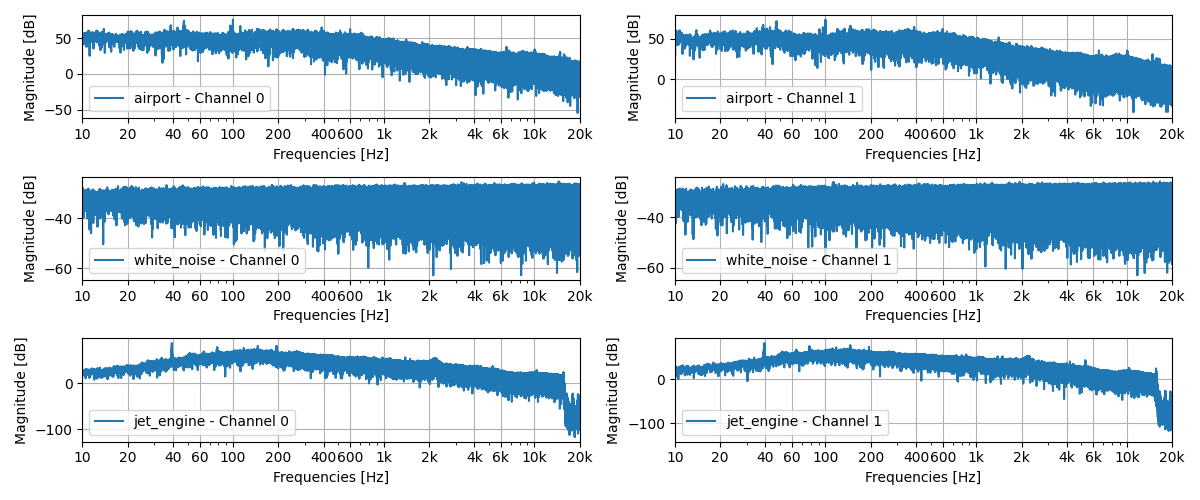

In [6]:
plot_freq(3, 2, audio)

### Butterworth Magnitude Spectrum ###

/var/folders/rv/4mmpnqxs5j10y9rblkr909nr0000gn/T/ipykernel_14057/2905461582.py:51: RuntimeWarning: divide by zero encountered in log10
  magnitude = 20 * np.log10(abs(impulse_response.freq))


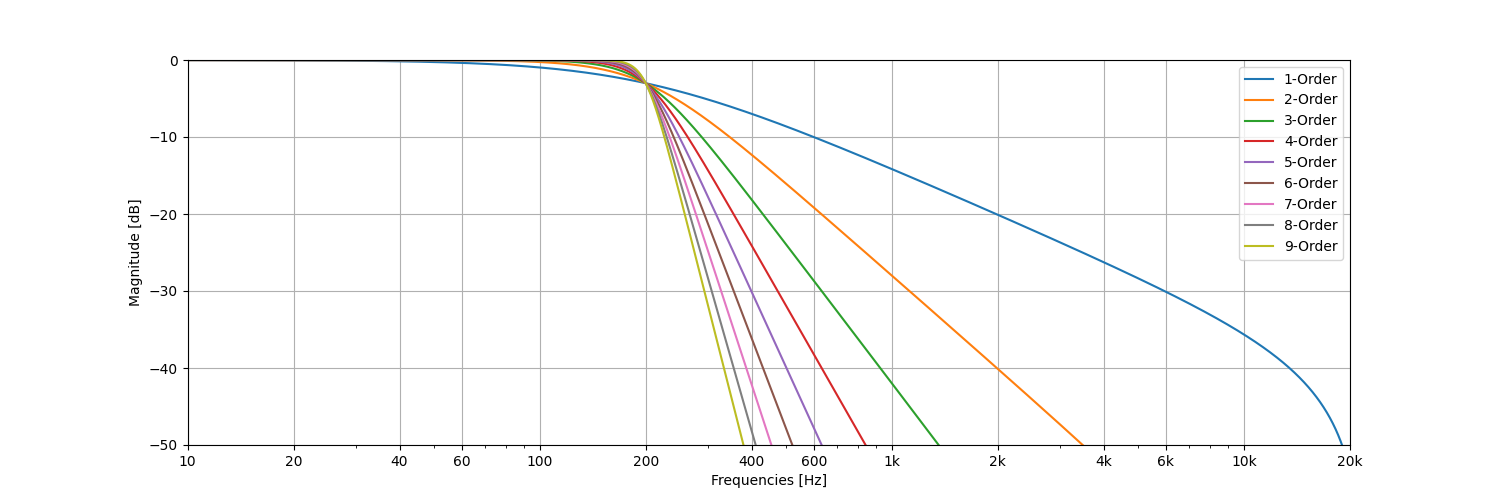

In [7]:
butterworths = []
butterworth_descriptors = []
for i in range(1,10):
    butterworths.append(get_butterworth(None, i, 200, sample_rate=44100))
    butterworth_descriptors.append(f"{i}-Order")
plot_impulse_response(butterworths, butterworth_descriptors)

### Bell Filter magnitude spectrum ###

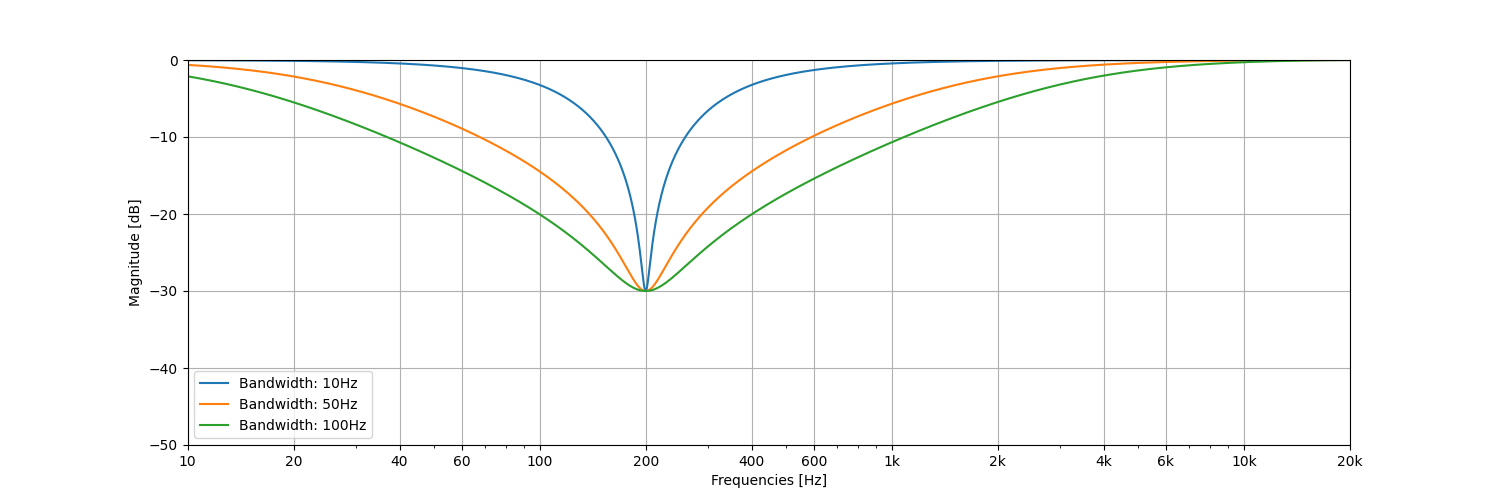

In [8]:
bandwidths = [10, 50, 100]
bells = []
bell_descriptors = []
for bandwidth in bandwidths:
    bells.append(get_bell(None, 200, -30, bandwidth, 44100))
    bell_descriptors.append(f"Bandwidth: {bandwidth}Hz")
plot_impulse_response(bells, bell_descriptors)

### Apply Butterworth Filter to Different Sounds and Plot the resulting spectrum ###

energy
power
energy


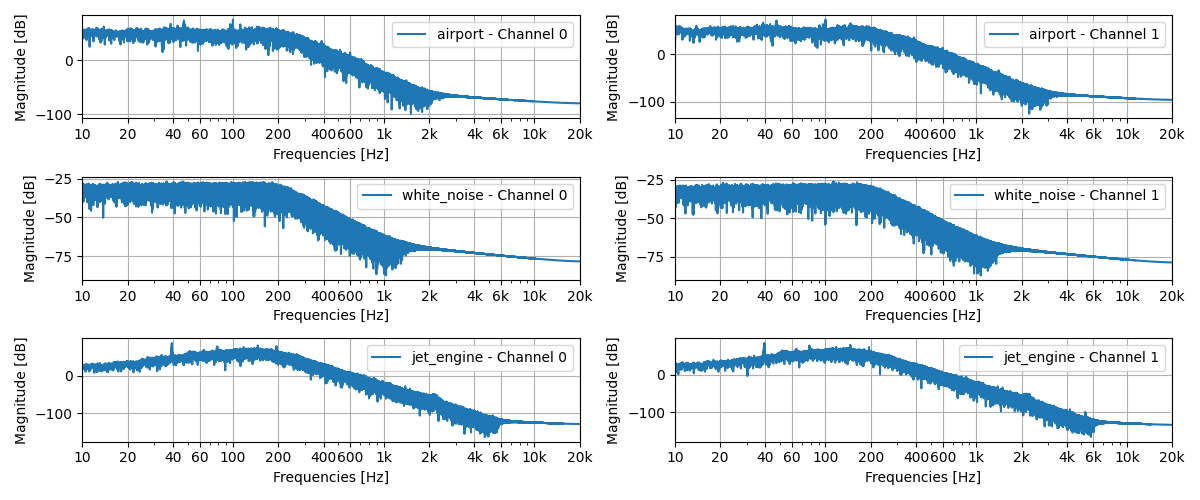

In [9]:
audio_butterworth = {}

for type, signal in audio.items():
    signal_filtered = get_butterworth(signal, 5, 200, None)
    audio_butterworth[f'{type}'] = signal_filtered
plot_freq(len(audio_butterworth.keys()), 2, audio_butterworth)

### Apply Bell Filter to Different Sounds and Plot the resulting spectrum ###

energy
power
energy


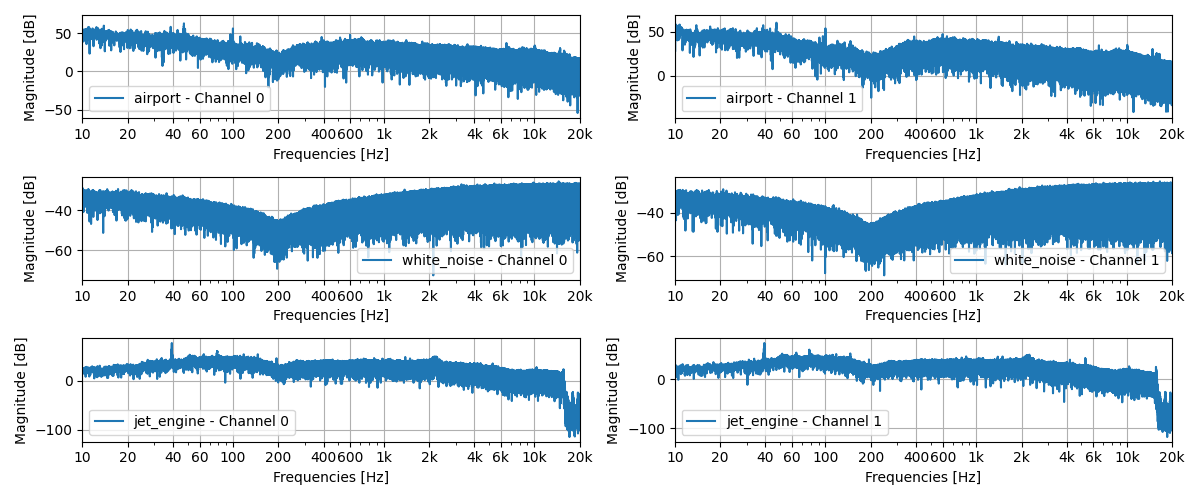

In [14]:
audio_bell = {}

for type, signal in audio.items():
    signal_filtered = get_bell(signal, 200, -35, 50, None)
    audio_bell[f'{type}'] = signal_filtered
plot_freq(len(audio_bell.keys()), 2, audio_bell)

### Play original audio ###

In [11]:
for type, signal in audio.items():
    play_original = create_play_button(f"Play original {type}", signal)
    box = widgets.HBox([play_original, stop_button])
    display(box)

### Play lowpass filtered audio ###

In [12]:
for type, signal in audio_butterworth.items():
    play_original = create_play_button(f"Play low pass filtered {type}", signal)
    box = widgets.HBox([play_original, stop_button])
    display(box)

### Play bell filtered audio ###

In [13]:
for type, signal in audio_bell.items():
    play_original = create_play_button(f"Play bell filtered {type}", signal)
    box = widgets.HBox([play_original, stop_button])
    display(box)